In [36]:
import imaging_behavior_functions
import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, TimeDistributed

In [2]:
base_path = "C:/Users/wilson/OneDrive - Harvard University/Thesis - Wilson lab/2P imaging/preprocessed data/qualified_sessions/multi_trial_sessions/with_odor/"
example_path_data = base_path+"20230529-3_MBON09_hDeltaB_syntGCAMP7f_odor/data/"
example_path_results = base_path+"20230529-3_MBON09_hDeltaB_syntGCAMP7f_odor/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [3]:
selected_df = neural_df.filter(like='hDeltaB')
selected_df

,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,hDeltaB_9,...,hDeltaB_11,hDeltaB_12,hDeltaB_13,hDeltaB_14,hDeltaB_15,hDeltaB_16,hDeltaB_17,hDeltaB_18,hDeltaB_19,hDeltaB_20
0,1.590838,0.735520,0.641548,0.692842,0.866954,0.763943,0.863997,0.916645,0.673691,1.525445,...,2.176712,1.462960,1.232131,1.032067,0.706348,0.425421,1.014452,0.676755,0.344793,0.111415
1,1.559020,0.922043,0.817839,0.736467,0.849124,0.823158,0.817577,0.979520,0.723363,1.625718,...,2.273949,1.694362,1.544201,1.144771,0.842663,0.653201,0.951931,0.920677,0.503818,0.318629
2,1.444763,1.022233,0.920657,0.766335,0.781021,0.746061,0.793546,0.983860,0.927996,1.797781,...,2.407882,1.883836,1.848538,1.314677,1.012601,0.898858,1.044521,1.109550,0.707051,0.480394
3,1.431276,1.057497,0.756452,0.731296,0.669075,0.545127,0.665388,0.834360,1.013022,2.035808,...,2.745381,2.212863,2.086307,1.496506,1.057245,1.082628,1.206423,1.225524,0.760744,0.538503
4,1.513375,1.050099,0.546538,0.557557,0.542239,0.392991,0.455136,0.658385,0.958424,2.202142,...,3.151800,2.557692,2.137304,1.798104,1.055213,1.158254,1.385705,1.364738,0.712912,0.532777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,1.869897,1.490332,1.345980,1.510160,1.321355,1.359485,0.621821,0.455027,0.387948,0.464127,...,0.780109,0.446613,0.734249,0.699040,0.484263,0.762138,1.153171,1.322167,1.405464,1.647470
1743,1.856835,1.689833,1.347858,1.460416,1.360768,1.411279,0.687017,0.583310,0.425251,0.426905,...,0.732679,0.344268,0.729412,0.639807,0.546390,0.670160,0.995137,1.502689,1.464547,1.834688
1744,1.791793,1.558499,1.275185,1.281542,1.256266,1.296330,0.596988,0.562734,0.487133,0.249100,...,0.463907,0.562606,0.701587,0.491743,0.635993,0.644363,1.039816,1.662676,1.435314,2.126265
1745,1.880841,1.374430,1.216998,1.153173,1.167017,1.269451,0.474110,0.466959,0.645554,0.140617,...,0.347312,0.809255,0.558380,0.260290,0.671195,0.668636,1.179824,1.633300,1.457536,2.203483


In [4]:
# mean MBON09
mean_MBON09 = np.array(neural_df.MBON09L + neural_df.MBON09R)
mean_MBON09

array([1.35784186, 1.56943847, 1.85284874, ..., 0.79372178, 0.70832508,
       0.59939807])

In [5]:
def perform_pca(selected_df, n_components=3):
    """
    Perform PCA on the given dataframe.

    Args:
    - data (pd.DataFrame): The dataframe containing neuron activity data.
    - n_components (int): The number of principal components to compute.

    Returns:
    - pca (PCA object): The PCA object after fitting the data.
    - transformed_data (np.array): Data transformed into principal components.
    - explained_variance_ratio (np.array): The amount of variance explained by each of the selected components.
    """
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(selected_df)

    # Perform PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(scaled_data)
    explained_variance_ratio = pca.explained_variance_ratio_

    return pca, transformed_data, explained_variance_ratio
pca, transformed_data, explained_variance_ratio = perform_pca(selected_df,n_components=3)

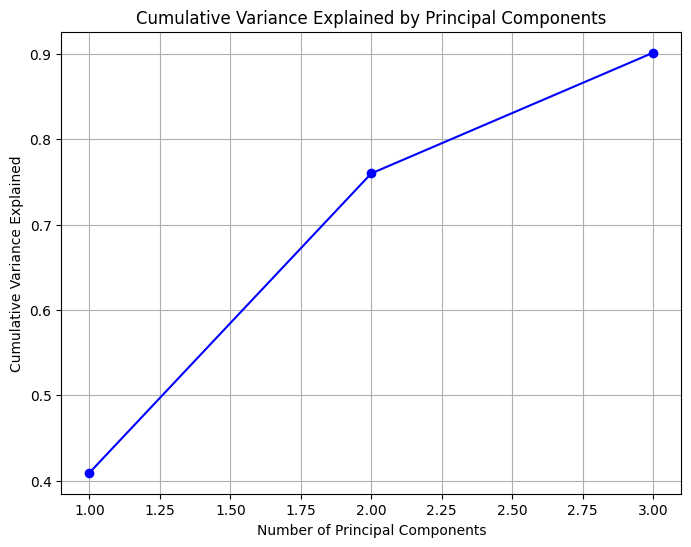

In [6]:
# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = 3
# Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [7]:
roi_kw = 'hDeltaB'
roi_mtx = imaging_behavior_functions.extract_heatmap(neural_df, roi_kw, 1, example_path_results, trial_num)
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,2.827433,0.201333,0.541886,0.321497,0.121208,0.168566
1,0.240513,2.827433,0.416882,0.448786,0.351794,0.109302,0.151199
2,0.481026,3.455752,0.617697,0.472955,0.300987,0.098905,0.137356
3,0.721539,3.769911,0.698740,0.754883,0.179406,0.095536,0.134785
4,0.962052,4.084070,0.721937,1.149012,0.137750,0.112476,0.159851
...,...,...,...,...,...,...,...
1742,418.973587,0.628319,0.432679,1.327284,0.114075,0.105814,0.147856
1743,419.214100,0.628319,0.481023,1.445989,0.096406,0.097546,0.136484
1744,419.454613,0.314159,0.407926,1.406939,0.096131,0.094277,0.131377
1745,419.695126,0.314159,0.321988,1.394511,0.107054,0.103838,0.144369


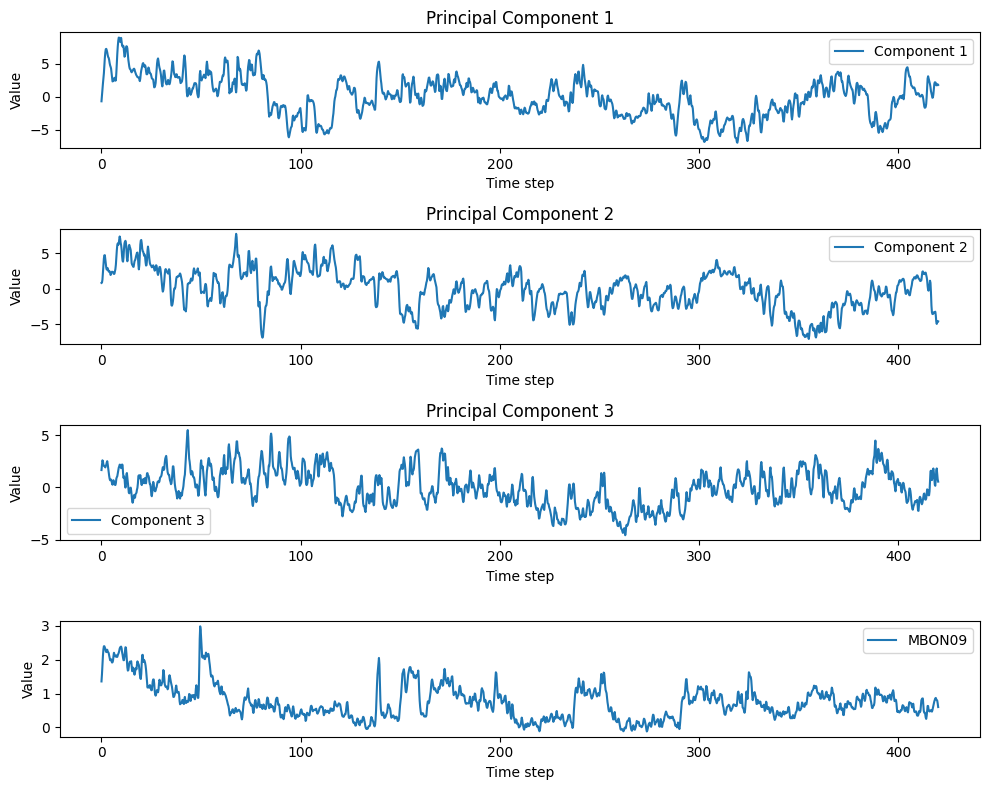

In [33]:
# visualze top PCstime_steps = range(transformed_data.shape[0])

n_components = 3
time_steps = range(transformed_data.shape[0])

# Create a figure with subplots
fig, axes = plt.subplots(n_components+1, 1, figsize=(10, 2*(n_components+1)))

for i in range(n_components):
    ax = axes[i]
    ax.plot(neural_df.time, transformed_data[:, i], label=f'Component {i+1}')
    ax.set_title(f'Principal Component {i+1}')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Value')
    ax.legend()
axes[n_components].plot(neural_df.time, mean_MBON09, label='MBON09')
axes[n_components].set_xlabel('Time step')
axes[n_components].set_ylabel('Value')
axes[n_components].legend()
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [9]:
# Concatenate your inputs to form a single feature vector per time frame
features = np.concatenate([transformed_data, np.array(behav_df[['yawV']]), mean_MBON09[:,np.newaxis]], axis=1)  # This will have shape (3554, 5)
# Create a scaler instance
scaler = StandardScaler()

# Fit the scaler to your features and transform them
features_scaled = scaler.fit_transform(features)

seq_length = 5  # Example sequence length
num_samples = features.shape[0] - seq_length

# Initialize X_train and y_train
X_train = np.zeros((num_samples, seq_length, features_scaled.shape[1]))  # Input sequences
y_train = np.zeros((num_samples, transformed_data.shape[1]))  # Target outputs (next time frame's x)

# Build the sequences
for i in range(num_samples):
    X_train[i] = features_scaled[i:i+seq_length]
    y_train[i] = transformed_data[i+seq_length]

# X_train is now formatted and ready for training, with shape (num_samples, seq_length, 5)
# y_train is the target state vectors, with shape (num_samples, 3)


In [10]:
num_features = features.shape[1]
num_target_features = transformed_data.shape[1]
hidden_units = 4
'''model = Sequential([
    SimpleRNN(8, activation='relu', input_shape=(None, num_features), ),  # Adjust 'None' for sequence length if fixed, and 'num_features' accordingly
    Dense(num_target_features, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64)
'''
inputs = Input(shape=(seq_length, num_features))
rnn_out = SimpleRNN(hidden_units, activation='relu', return_sequences=True)(inputs)  # Keep return_sequences=True for analysis
# Extract the last timestep output for prediction purposes
last_timestep_output = rnn_out[:, -1, :]
predictions = Dense(num_target_features, activation='linear')(last_timestep_output)

# Full model for training
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2, batch_size=64)



Epoch 1/150

22/22 [==============================] - 2s 19ms/step - loss: 8.5684 - val_loss: 7.6766
Epoch 2/150
22/22 [==============================] - 0s 4ms/step - loss: 7.8691 - val_loss: 7.3832
Epoch 3/150
22/22 [==============================] - 0s 4ms/step - loss: 7.4309 - val_loss: 7.1704
Epoch 4/150
22/22 [==============================] - 0s 5ms/step - loss: 7.1326 - val_loss: 6.9906
Epoch 5/150
22/22 [==============================] - 0s 4ms/step - loss: 6.9185 - val_loss: 6.8496
Epoch 6/150
22/22 [==============================] - 0s 4ms/step - loss: 6.7417 - val_loss: 6.7196
Epoch 7/150
22/22 [==============================] - 0s 4ms/step - loss: 6.5915 - val_loss: 6.6070
Epoch 8/150
22/22 [==============================] - 0s 4ms/step - loss: 6.4578 - val_loss: 6.5062
Epoch 9/150
22/22 [==============================] - 0s 4ms/step - loss: 6.3352 - val_loss: 6.4192
Epoch 10/150
22/22 [==============================] - 0s 4ms/step - loss: 6.2157 - val_loss: 6.3293
Epoch 

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 4)              40        
                                                                 
 tf.__operators__.getitem (  (None, 4)                 0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 55 (220.00 Byte)
Trainable params: 55 (220.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


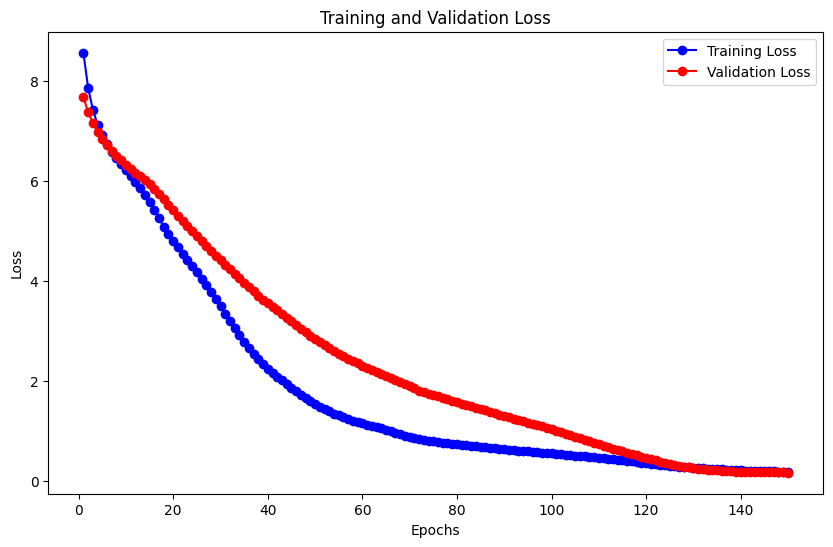

In [12]:

# Assuming 'history' is the object returned by the model.fit call
# It contains training and validation loss values among other things

# Extract the loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)  # Number of epochs

# Create a line plot for the loss
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the figure
plt.plot(epochs, loss, 'bo-', label='Training Loss')  # 'bo-' gives blue color, circle markers, and solid line
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # 'ro-' gives red color, circle markers, and solid line
plt.title('Training and Validation Loss')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Adds a legend to specify which line is which

plt.show()  # Displays the plot


55/55 [==============================] - 0s 1ms/step


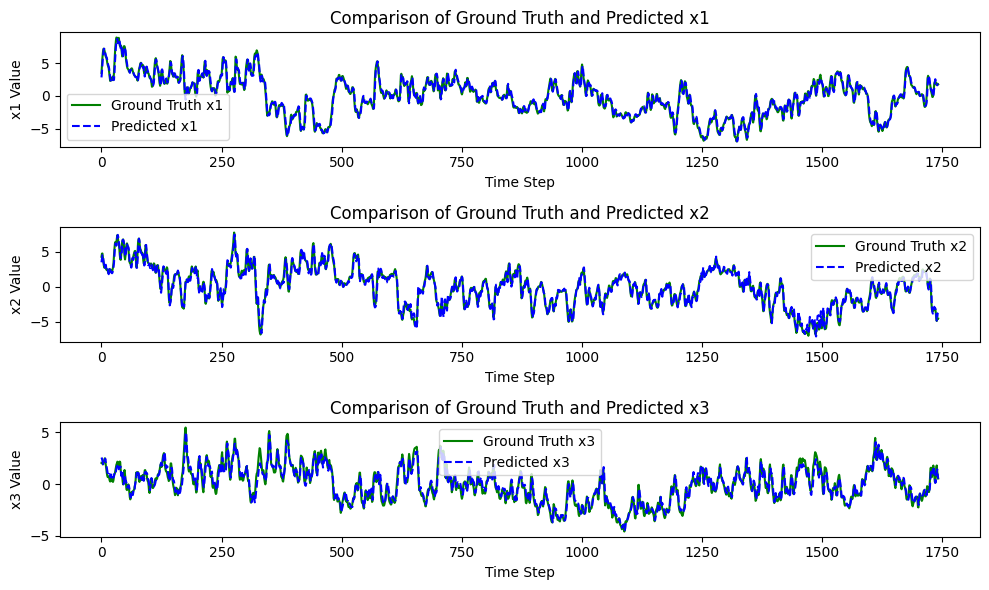

In [13]:
y_train_pred = model.predict(X_train)
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

# Plotting the first dimension
axs[0].plot(y_train[:,0], 'g-', label='Ground Truth x1')  # Green solid line
axs[0].plot(y_train_pred[:,0], 'b--', label='Predicted x1')  # Blue dashed line
axs[0].set_title('Comparison of Ground Truth and Predicted x1')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('x1 Value')
axs[0].legend()

# Plotting the second dimension
axs[1].plot(y_train[:,1], 'g-', label='Ground Truth x2')  # Green solid line
axs[1].plot(y_train_pred[:,1], 'b--', label='Predicted x2')  # Blue dashed line
axs[1].set_title('Comparison of Ground Truth and Predicted x2')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('x2 Value')
axs[1].legend()

# Plotting the third dimension
axs[2].plot(y_train[:,2], 'g-', label='Ground Truth x3')  # Green solid line
axs[2].plot(y_train_pred[:,2], 'b--', label='Predicted x3')  # Blue dashed line
axs[2].set_title('Comparison of Ground Truth and Predicted x3')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('x3 Value')
axs[2].legend()

plt.tight_layout()  # Adjust the layout to make room for the titles and labels
plt.show()


## recurrent weights visualization

In [14]:
def get_rnn_layer(model, substring="rnn"):
    """
    Fetch the first layer that contains a specified substring in its name.

    Parameters:
    - model: The model from which to fetch the layer.
    - substring: The substring to look for in the layer names.

    Returns:
    - The first layer that contains the specified substring in its name, or None if no such layer is found.
    """
    for layer in model.layers:
        if substring in layer.name:
            return layer
    return None



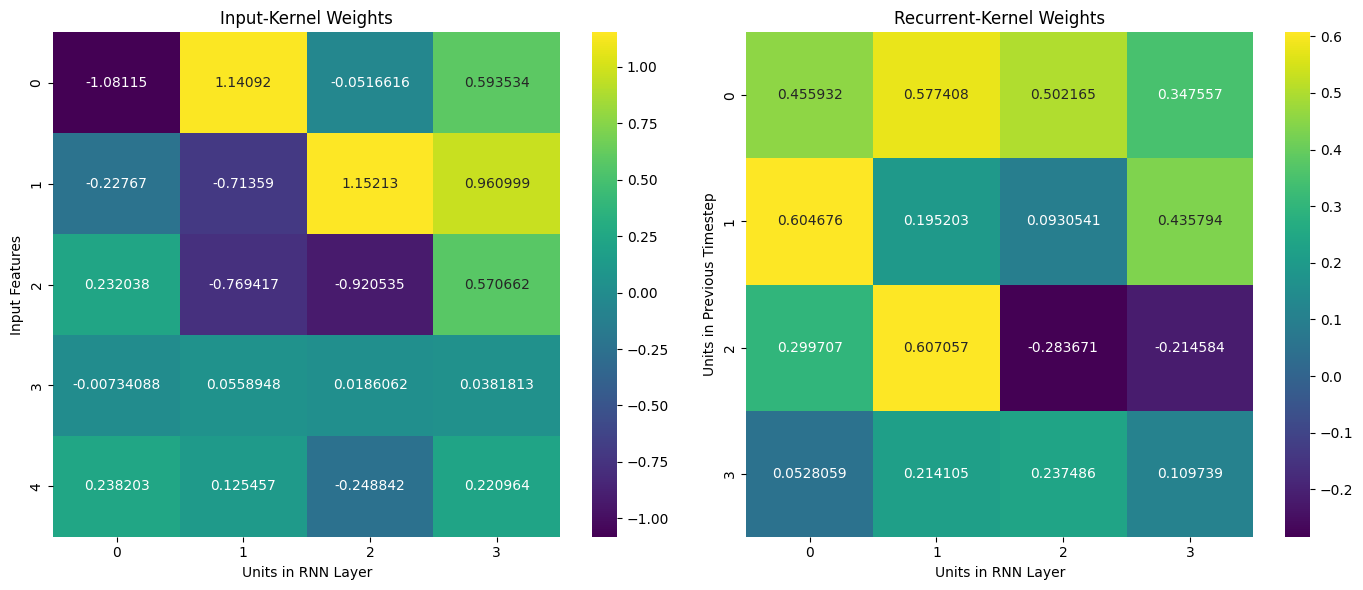

In [15]:
# Extract weights
rnn_layer = get_rnn_layer(model,'rnn')
weights = rnn_layer.get_weights()

# weights[0] are the weights for the input (kernel)
# weights[1] are the recurrent weights (recurrent_kernel)
# weights[2] are the biases (not visualized here but can be, similar to weights)

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot input-kernel weights
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(weights[0], annot=True, cmap='viridis', fmt='g')
plt.title('Input-Kernel Weights')
plt.xlabel('Units in RNN Layer')
plt.ylabel('Input Features')

# Plot recurrent-kernel weights
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(weights[1], annot=True, cmap='viridis', fmt='g')
plt.title('Recurrent-Kernel Weights')
plt.xlabel('Units in RNN Layer')
plt.ylabel('Units in Previous Timestep')

plt.tight_layout()
plt.show()


## output weights visualization

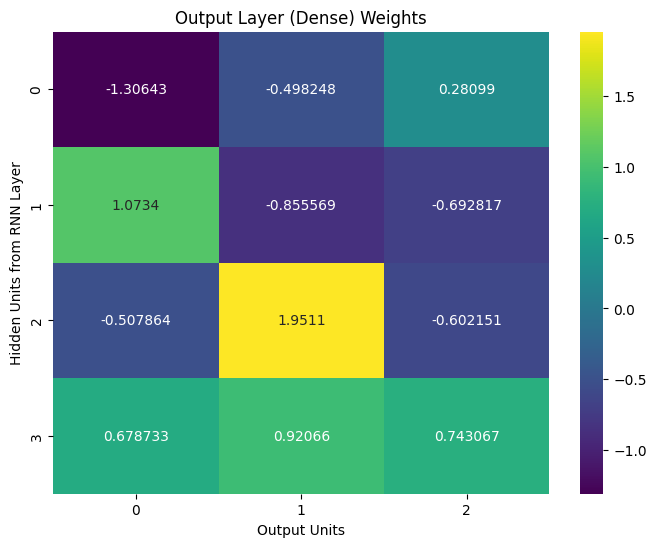

In [16]:
# Extract weights from the Dense layer
dense_layer = get_rnn_layer(model,'dense')
dense_weights = dense_layer.get_weights()

# dense_weights[0] are the weights of the dense layer (connecting RNN to output)
# dense_weights[1] are the biases of the dense layer

# Visualize the Dense layer weights
plt.figure(figsize=(8, 6))
sns.heatmap(dense_weights[0], annot=True, cmap='viridis', fmt='g')
plt.title('Output Layer (Dense) Weights')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units from RNN Layer')
plt.show()


## Gradient heatmap

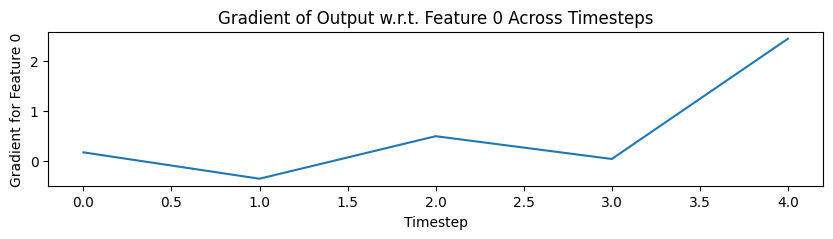

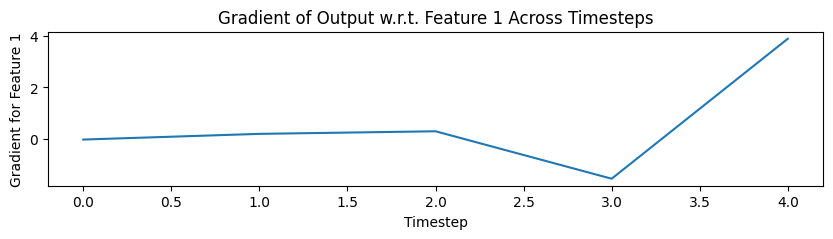

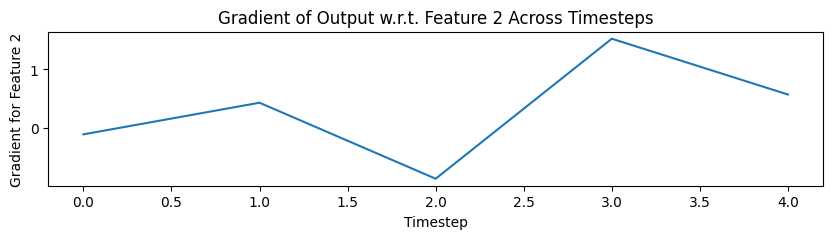

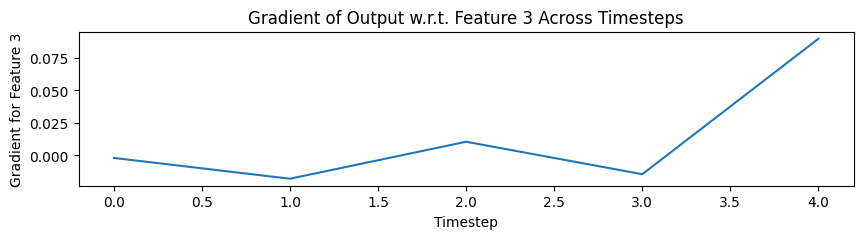

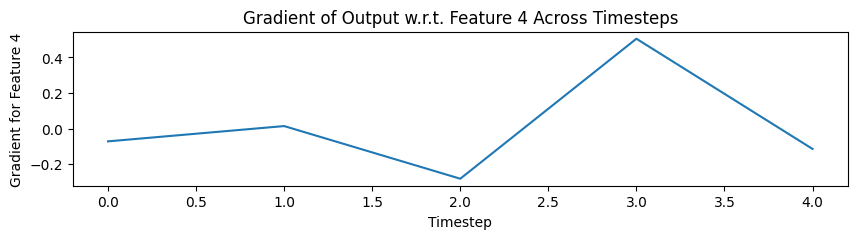

In [17]:
def compute_and_plot_gradients(model, X, input_sample_index, feature_index):
    """
    Compute and plot the gradients of the model's output with respect to an input sample for a specific feature.
    
    Parameters:
    - model: The trained RNN model.
    - X_test: The test dataset as a TensorFlow tensor or a numpy array.
    - input_sample_index: The index of the sample in X_test to analyze.
    - feature_index: The index of the feature for which to plot the gradients.
    """
    # Ensure X_test is a TensorFlow tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    
    # Select the specified input sample
    input_sample_tensor = X_tensor[input_sample_index:input_sample_index+1]
    
    # Watch the input sample tensor to compute gradients
    with tf.GradientTape() as tape:
        tape.watch(input_sample_tensor)
        predictions = model(input_sample_tensor)
    
    # Compute the gradients of the output with respect to the input
    gradients = tape.gradient(predictions, input_sample_tensor)
    
    # Extract the gradients for the specified feature across all timesteps
    gradients_for_feature = gradients[0, :, feature_index]
    
    # Plot the gradients
    plt.figure(figsize=(10, 2))
    plt.plot(gradients_for_feature)
    plt.title(f'Gradient of Output w.r.t. Feature {feature_index} Across Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel(f'Gradient for Feature {feature_index}')
    plt.show()

# Example usage:
input_sample_index = 0
#feature_index=0
for i in range(num_features):
    compute_and_plot_gradients(model, X_train, input_sample_index, i)



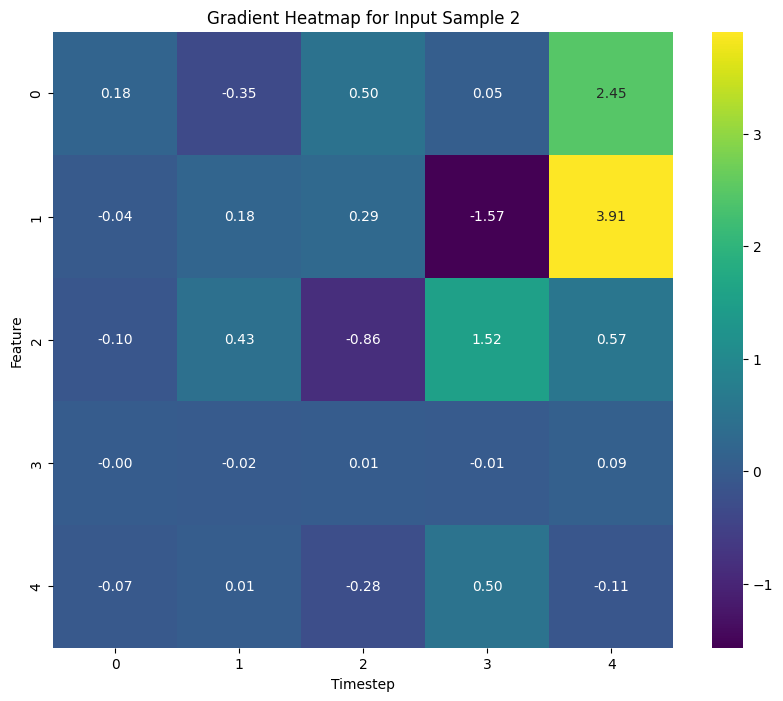

In [18]:
def plot_gradient_heatmap(model, X, input_sample_index):
    """
    Plot a heatmap of the gradients of the model's output with respect to all features across all timesteps 
    for a specified input sample.
    
    Parameters:
    - model: The trained RNN model.
    - X_test: The test dataset as a TensorFlow tensor or a numpy array.
    - input_sample_index: The index of the sample in X_test to analyze.
    """
    # Ensure X_test is a TensorFlow tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    
    # Select the specified input sample
    input_sample_tensor = X_tensor[input_sample_index:input_sample_index+1]
    
    # Watch the input sample tensor to compute gradients
    with tf.GradientTape() as tape:
        tape.watch(input_sample_tensor)
        predictions = model(input_sample_tensor)
    
    # Compute the gradients of the output with respect to the input
    gradients = tape.gradient(predictions, input_sample_tensor)
    
    # Extract the gradients for all features across all timesteps
    gradients_numpy = gradients.numpy()[0]  # Assuming the output is (1, timesteps, features)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(gradients_numpy.T, cmap='viridis', annot=True, fmt=".2f")
    ax.set_title(f'Gradient Heatmap for Input Sample {input_sample_index}')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Feature')
    plt.show()

# Example usage:
input_sample_index = 2
plot_gradient_heatmap(model, X_train, input_sample_index)


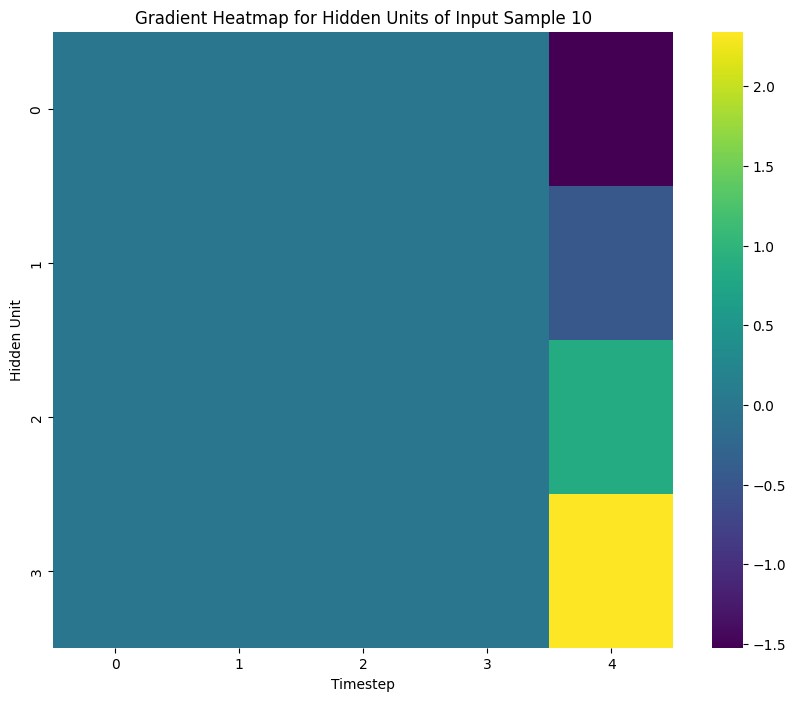

In [19]:

# Assuming 'model' is your original trained model
# Modify the model to also output the RNN layer's activations
rnn_layer_output = model.layers[1].output  # Assuming the RNN layer is at index 1
modified_model = Model(inputs=model.input, outputs=[model.output, rnn_layer_output])

# Select an input sample
input_sample_index = 10
input_sample_tensor = tf.convert_to_tensor(X_train[input_sample_index:input_sample_index+1], dtype=tf.float32)

# Use GradientTape to watch the intermediate activations
with tf.GradientTape() as tape:
    # predictions_and_activations will hold both the final predictions and the RNN layer's activations
    predictions_and_activations = modified_model(input_sample_tensor)
    predictions = predictions_and_activations[0]
    activations = predictions_and_activations[1]

# Now, compute gradients of the predictions with respect to the activations
gradients = tape.gradient(predictions, activations)

# Since we're interested in visualizing these gradients, continue as before
gradients_numpy = gradients.numpy().squeeze().T  # (units, timesteps)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(gradients_numpy, cmap='viridis', annot=False)
ax.set_title(f'Gradient Heatmap for Hidden Units of Input Sample {input_sample_index}')
ax.set_xlabel('Timestep')
ax.set_ylabel('Hidden Unit')
plt.show()


## tensorboard visualization

In [20]:
# TODO: figure ouot tensorboard 
log_dir = 'logs/model_graph'

# Ensure compatibility with newer TensorFlow versions for TensorBoard
tf.summary.create_file_writer(log_dir)

sample_input = tf.constant(X_train[0:1], dtype=tf.float32)

# Start recording the computation graph without profiler to avoid deprecation warnings
tf.summary.trace_on(graph=True)

_ = model(sample_input)

# Save the recorded graph to the log directory
with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.trace_export(name="model_graph", step=0)


## activations

In [21]:
layer_outputs = [layer.output for layer in model.layers if 'simple_rnn' in layer.name]  # Get the SimpleRNN layer output
activation_model = Model(inputs=model.input, outputs=layer_outputs)

1/1 [==============================] - 0s 143ms/step


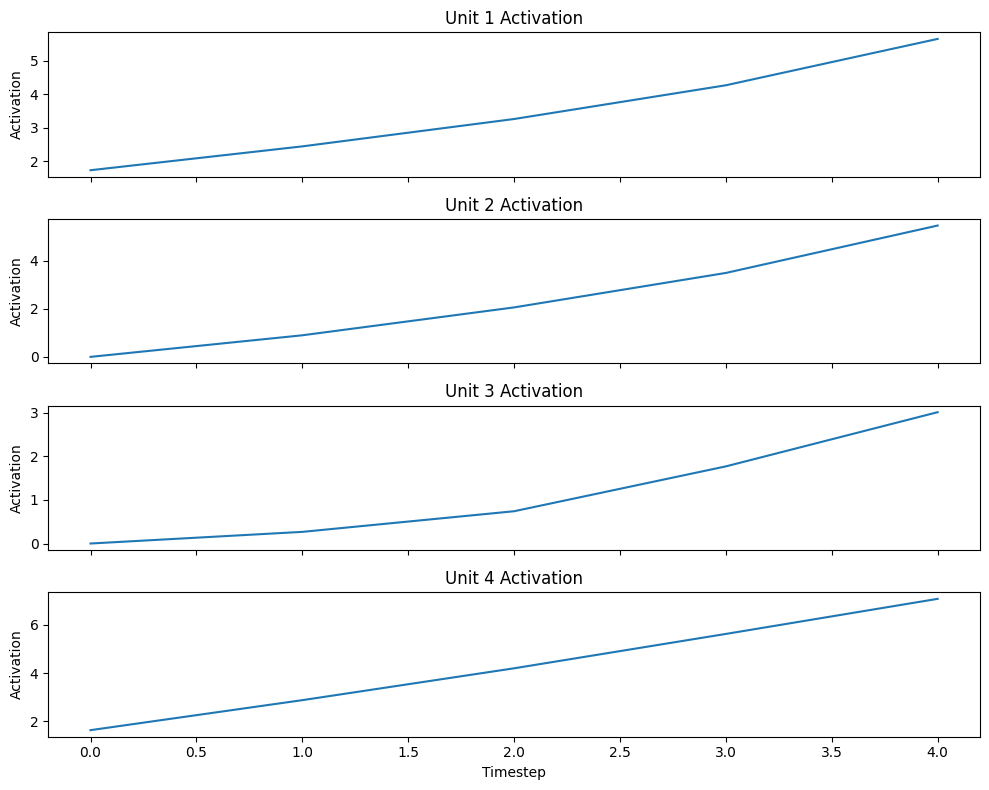

In [22]:
# Assuming you have an input sample you want to analyze
input_sample = X_train[0:1]  # For example, take the first sample from the test set

# Get the activations
activations = activation_model.predict(input_sample)
# Adjust 'activations[0]' if you have multiple layers you're extracting activations from
rnn_activations = activations[0]  # Shape: (1, timesteps, units)

# Remove the batch dimension
rnn_activations = rnn_activations.squeeze()  # Now shape is (timesteps, units)

# Plotting
n_units = rnn_activations.shape[1]
fig, axs = plt.subplots(n_units, 1, figsize=(10, n_units * 2), sharex=True)

if n_units == 1:
    axs = [axs]  # Ensure axs is iterable

for i, ax in enumerate(axs):
    ax.plot(rnn_activations[:, i])
    ax.set_title(f'Unit {i+1} Activation')
    ax.set_ylabel('Activation')
axs[-1].set_xlabel('Timestep')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 22ms/step


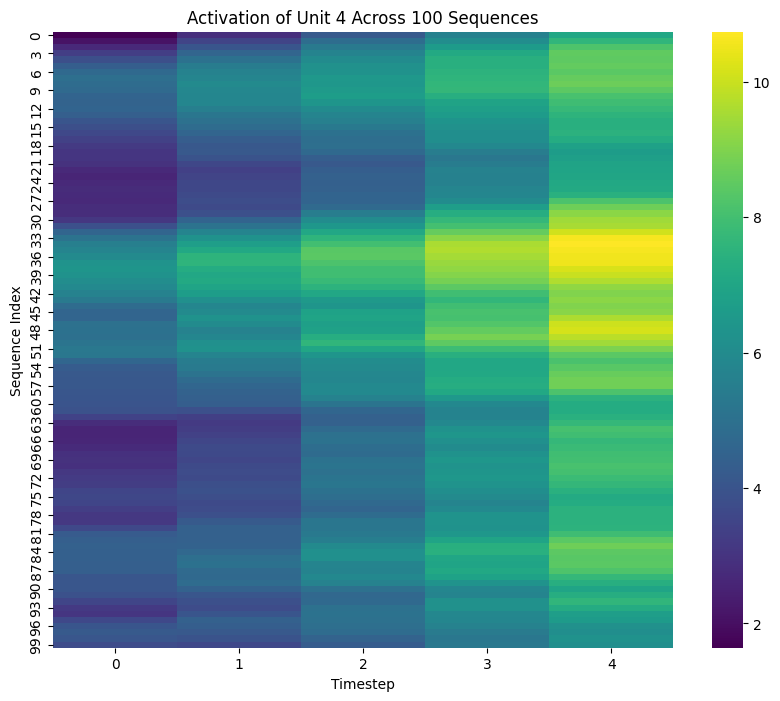

In [23]:
unit_index = 3  # Index of the unit you're interested in
num_samples = 100  # Number of samples you want to analyze, adjust as needed

# Initialize an array to store the activations
unit_activations = np.zeros((num_samples, seq_length))  # Assuming fixed seq_length for simplicity

# Collect activations
for i in range(num_samples):
    input_sample = X_train[i:i+1]  # Selecting individual samples
    activations = activation_model.predict(input_sample)
    rnn_activations = activations[0].squeeze()  # Shape: (timesteps, units)
    unit_activations[i] = rnn_activations[:, unit_index]


plt.figure(figsize=(10, 8))
sns.heatmap(unit_activations, cmap='viridis')
plt.title(f'Activation of Unit {unit_index+1} Across {num_samples} Sequences')
plt.xlabel('Timestep')
plt.ylabel('Sequence Index')
plt.show()


In [24]:
rnn_out

<KerasTensor: shape=(None, 5, 4) dtype=float32 (created by layer 'simple_rnn')>

In [26]:

# Assuming `features` is your entire dataset of shape (3554, num_features)
seq_length = 5  # The length of your input sequences
hidden_units = 4  # Assuming there are 4 hidden units in the RNN
#model_with_activations = Model(inputs=inputs, outputs=[predictions, rnn_out])
# Initialize an array to store the activations
# For each of the 3554 timesteps, we want to store the activation of the last timestep
# in the sequence processed by the model, which reflects the most up-to-date state
all_activations = np.zeros((features.shape[0], hidden_units))

for i in range(seq_length, features.shape[0]):
    # Prepare the input sequence
    input_seq = features[i-seq_length:i].reshape(1, seq_length, -1)
    
    # Get the activations from your model
    # Modify this line according to how your model_with_activations is set up
    activations = activation_model.predict(input_seq)
    
    # Store the activations from the last timestep of the sequence
    all_activations[i] = activations[0, -1, :]  # Shape: (hidden_units,)

# Note: The first few timesteps (less than seq_length) won't have activations in this setup
# because they don't form a complete sequence on their own.
# You might choose to handle this by padding or similar strategies depending on your needs.


1/1 [==============================] - 0s 21ms/step


In [27]:
np.shape(all_activations)

(1747, 4)

In [28]:
def plot_pairwise_state_space_trajectories(activations, title='State Space Trajectory'):
    """
    Plots pairwise state space trajectories of hidden unit activations.

    Parameters:
    - activations: A numpy array of shape (time_steps, hidden_units) containing the activations of the hidden units.
    - title: A title for the plots.
    """
    num_units = activations.shape[1]
    fig, axs = plt.subplots(nrows=num_units-1, ncols=num_units-1, figsize=(12, 12))
    fig.suptitle(title)
    # Normalize the color_values for color mapping
    norm = plt.Normalize(mean_MBON09.min(), mean_MBON09.max())
    cmap = cm.viridis  # Choose a colormap
    for i in range(num_units):
        for j in range(i+1, num_units):
            ax = axs[j-1, i]
            ax.plot(activations[:, i], activations[:, j], marker='o', markersize=2, linestyle='-')
            ax.set_xlabel(f'Unit {i+1} Activation')
            ax.set_ylabel(f'Unit {j+1} Activation')
            ax.grid(True)
    
    # Hide empty subplots
    for i in range(num_units - 1):
        for j in range(i+1, num_units - 1):
            axs[i, j].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


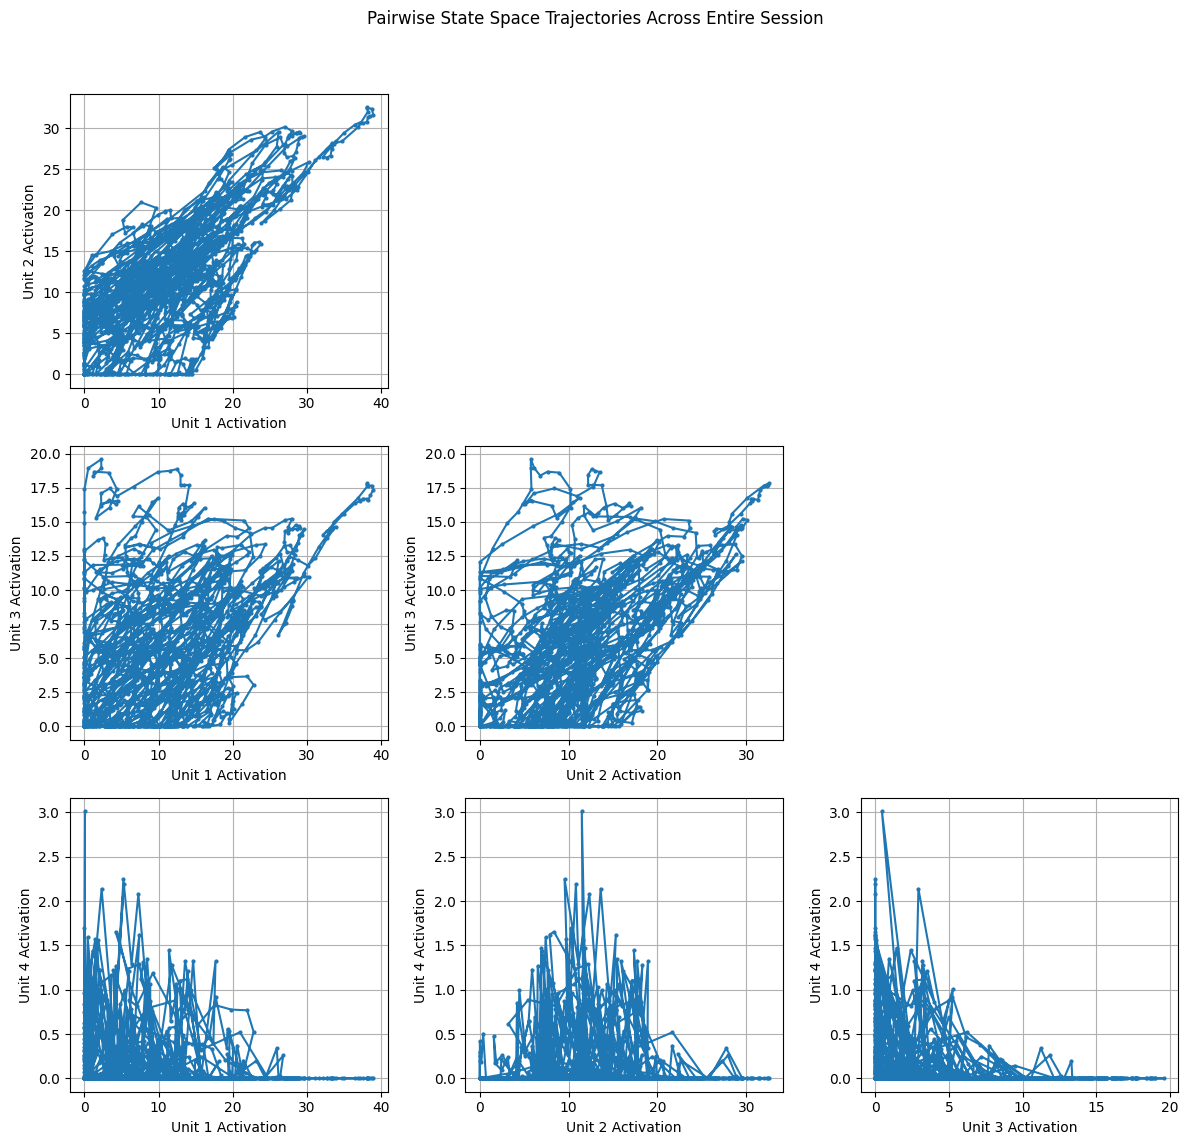

In [ ]:
plot_pairwise_state_space_trajectories(all_activations, title='Pairwise State Space Trajectories Across Entire Session')

In [34]:


# Assuming hidden_activations has shape (time_steps, hidden_units)
# and you're interested in visualizing transitions for the first two units

# Extract the activations for the first two units
activations_unit_1 = all_activations[:-1, 0]  # All but the last timestep for unit 1
activations_unit_2 = all_activations[:-1, 1]  # All but the last timestep for unit 2

# Calculate the differences (deltas) to represent the transitions
deltas_unit_1 = np.diff(all_activations[:, 0])  # Differences along unit 1
deltas_unit_2 = np.diff(all_activations[:, 1])  # Differences along unit 2


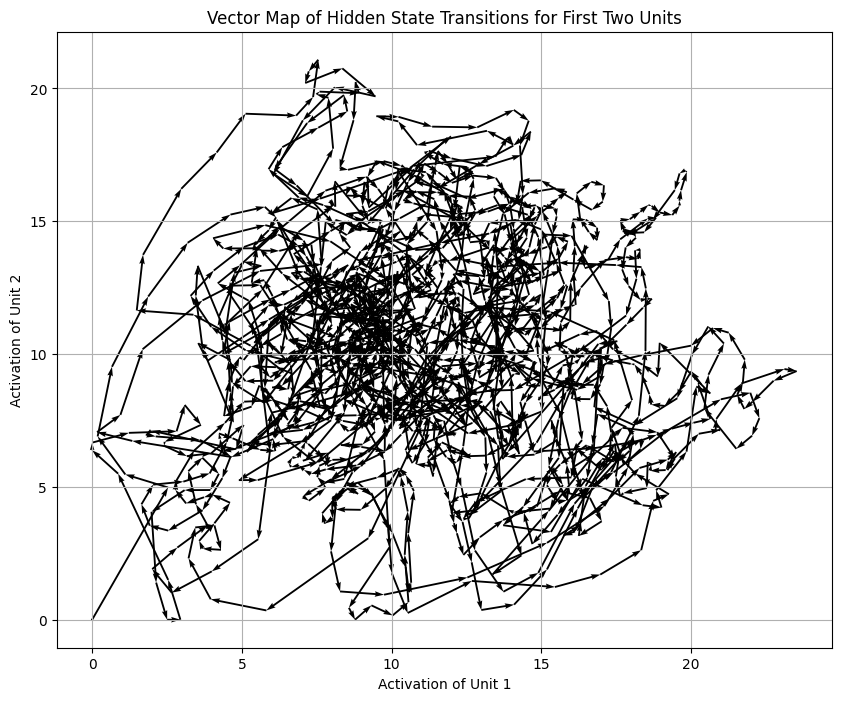

In [35]:
plt.figure(figsize=(10, 8))
plt.quiver(activations_unit_1, activations_unit_2, deltas_unit_1, deltas_unit_2, angles='xy', scale_units='xy', scale=1)
plt.xlabel('Activation of Unit 1')
plt.ylabel('Activation of Unit 2')
plt.title('Vector Map of Hidden State Transitions for First Two Units')
plt.grid(True)
plt.show()


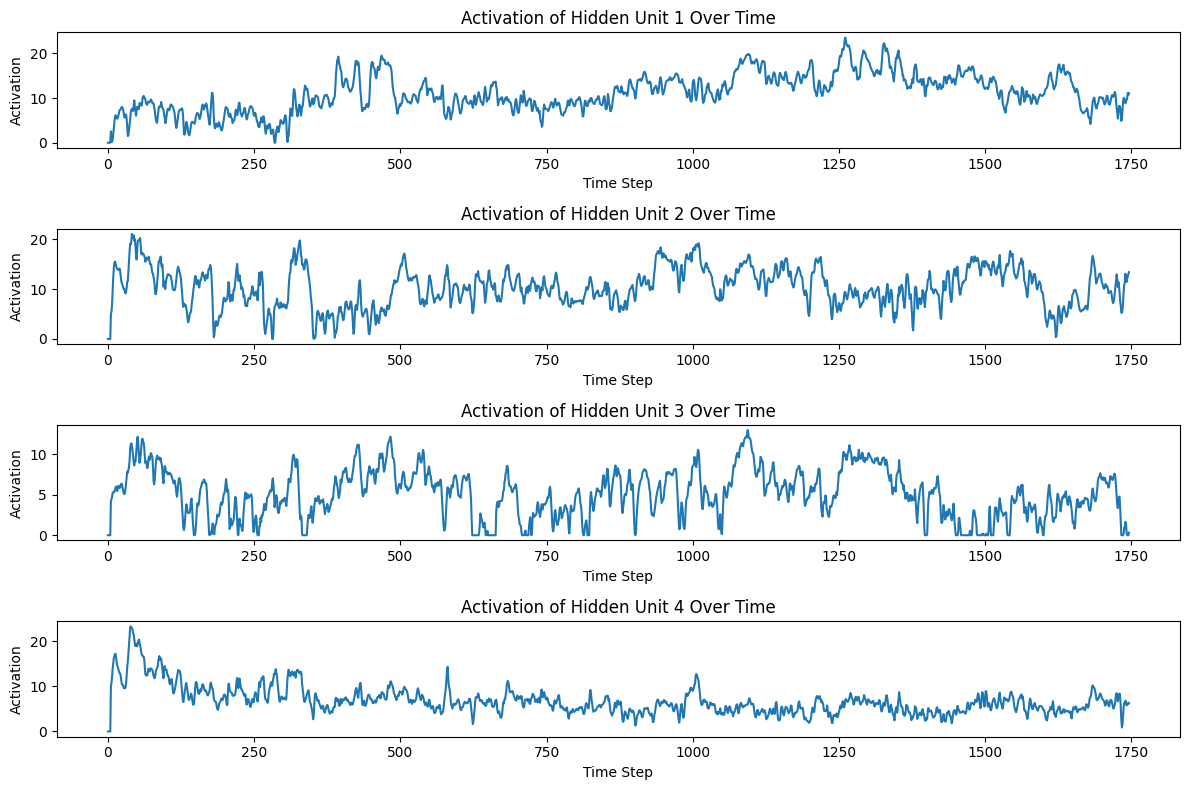

In [30]:
import matplotlib.pyplot as plt

# Number of hidden units
hidden_units = all_activations.shape[1]

# Create a figure and subplots
fig, axs = plt.subplots(hidden_units, 1, figsize=(12, hidden_units * 2))

# Check if there's only one subplot (in case of a single hidden unit)
if hidden_units == 1:
    axs = [axs]

# Plot the activation for each hidden unit
for i in range(hidden_units):
    axs[i].plot(all_activations[:, i])
    axs[i].set_title(f'Activation of Hidden Unit {i+1} Over Time')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Activation')

plt.tight_layout()
plt.show()


In [ ]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
phase = np.array(param_df.phase)

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1,
    y=pc2,
    z=pc3,
    mode='markers',
    marker=dict(
        size=5,
        color=phase,  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='Phase'),
        opacity=0.8
    )
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [ ]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
amplitude = np.array(param_df.amplitude)

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1,
    y=pc2,
    z=pc3,
    mode='markers',
    marker=dict(
        size=5,
        color=amplitude,  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='Amplitude'),
        opacity=0.8
    )
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [ ]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
baseline = np.array(param_df.baseline)

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1,
    y=pc2,
    z=pc3,
    mode='markers',
    marker=dict(
        size=4,
        color=baseline,  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='Baseline'),
        opacity=0.5
    )
)])

'''for idx in big_drop_indices:
    fig.add_trace(go.Scatter3d(x=pc1[idx:idx+2], y=pc2[idx:idx+2], z=pc3[idx:idx+2],
                               mode='lines',
                               line=dict(color='red', width=2)))

for idx in big_increase_indices:
    fig.add_trace(go.Scatter3d(x=pc1[idx:idx+2], y=pc2[idx:idx+2], z=pc3[idx:idx+2],
                               mode='lines',
                               line=dict(color='black', width=2)))'''    
# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [ ]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
#MBON09 = np.array(param_df.baseline)

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1,
    y=pc2,
    z=pc3,
    mode='markers',
    marker=dict(
        size=4,
        color=mean_MBON09,  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='MBON09'),
        opacity=0.5
    )
)])

'''for idx in big_drop_indices:
    fig.add_trace(go.Scatter3d(x=pc1[idx:idx+2], y=pc2[idx:idx+2], z=pc3[idx:idx+2],
                               mode='lines',
                               line=dict(color='red', width=2)))

for idx in big_increase_indices:
    fig.add_trace(go.Scatter3d(x=pc1[idx:idx+2], y=pc2[idx:idx+2], z=pc3[idx:idx+2],
                               mode='lines',
                               line=dict(color='black', width=2)))'''    
# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [ ]:
# Extract the first three PCs
pc1 = gaussian_filter1d(transformed_data[:, 0], sigma=5)
pc2 = gaussian_filter1d(transformed_data[:, 1],sigma=5)
pc3 = gaussian_filter1d(transformed_data[:, 2],sigma=5)

# Time steps for coloring
#lower_threshold = np.percentile(smoothed_df.fwV_smoothed, 5)
#upper_threshold = np.percentile(smoothed_df.fwV_smoothed, 95)
#color_var = np.abs(np.clip(smoothed_df.fwV_smoothed,lower_threshold, upper_threshold))
color_var = neural_df.time

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1,
    y=pc2,
    z=pc3,
    mode='markers',
    marker=dict(size=5, color=color_var, colorscale='Viridis')
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()
